In [244]:
import torch as torch
from torch import nn
import torchvision.datasets as dset
import torchvision.transforms as transforms
import torchvision.utils as vutils
import matplotlib.pyplot as plt
import matplotlib as matplotlib

In [245]:
matplotlib.colors.Normalize(vmin=-1, vmax=1, clip=False)

In [246]:
if torch.cuda.is_available():
    cuda_id = torch.cuda.current_device()
    device_name = torch.cuda.get_device_name(cuda_id)
    device = "cuda:0"
else:
    device = "cpu"

In [247]:
torch.manual_seed(42)

## Creating Discriminator and Generator model classes

In [248]:
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.network = nn.Sequential(
            nn.Conv2d(3, 32, 4, 2, 1, bias=False),
            nn.BatchNorm2d(32),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(32, 64, 4, 2, 1, bias=False),
            nn.BatchNorm2d(64),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(64, 64, 4, 2, 1, bias=False),
            nn.BatchNorm2d(64),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Flatten(),
            nn.Dropout(0.2),
            nn.Linear(1024, 1),
            nn.Sigmoid(),
        )

    def forward(self, img):
        return self.network(img)

In [249]:
class Reshape(nn.Module):
    def __init__(self, shape):
        super(Reshape, self).__init__()
        self.shape = shape

    def forward(self, input):
        return torch.reshape(input, self.shape)


class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
        self.network = nn.Sequential(
            nn.Linear(64, 1024),
            Reshape((-1, 64, 4, 4)),
            nn.ConvTranspose2d(64, 64, 4, 2, 1, bias=False),
            # nn.BatchNorm2d(64),
            nn.LeakyReLU(0.2, inplace=True),
            nn.ConvTranspose2d(64, 128, 4, 2, 1, bias=False),
            # nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2, inplace=True),
            nn.ConvTranspose2d(128, 256, 4, 2, 1, bias=False),
            # nn.BatchNorm2d(256),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(256, 3, 5, 1, 2, bias=False),
            nn.Tanh(),
        )

    def forward(self, img):
        return self.network(img)

In [250]:
# return a vector of n samples from N(0,1) distribution
get_normal = lambda n: torch.normal(torch.zeros(n), 1).to(device)
normal_vector = get_normal(64)

In [251]:
generator = Generator().to(device)
forwarded_random_image = generator.forward(normal_vector)
forwarded_random_image.shape

torch.Size([1, 3, 32, 32])

In [252]:
def scale_and_display(image, normalize=False):
    if normalize:
        value_range = (image.min(), image.max())
    else:
        value_range = (-1, 1)
    plt.figure(figsize=(8, 8))
    plt.axis("off")
    plt.imshow(
        (
            vutils.make_grid(
                image, nrow=4, padding=2, normalize=True, value_range=value_range
            )
            .permute(1, 2, 0)
            .detach()
            .cpu()
            .numpy()
        )
    )
    plt.show()

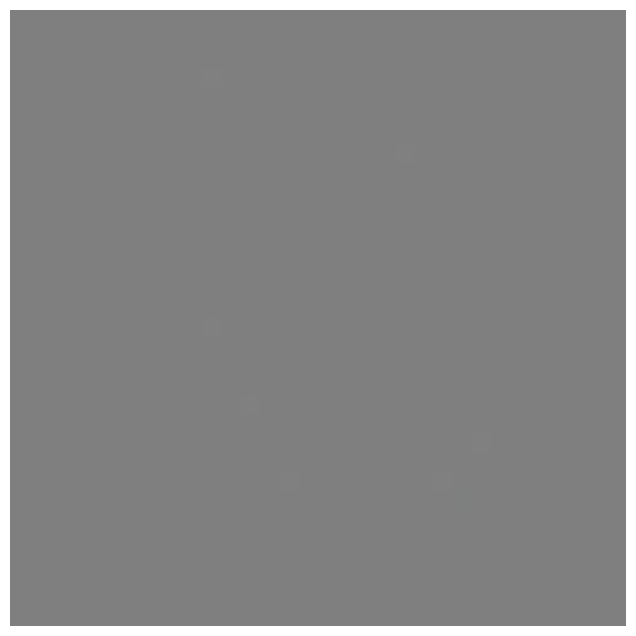

In [253]:
scale_and_display(torch.clone(forwarded_random_image).cpu())

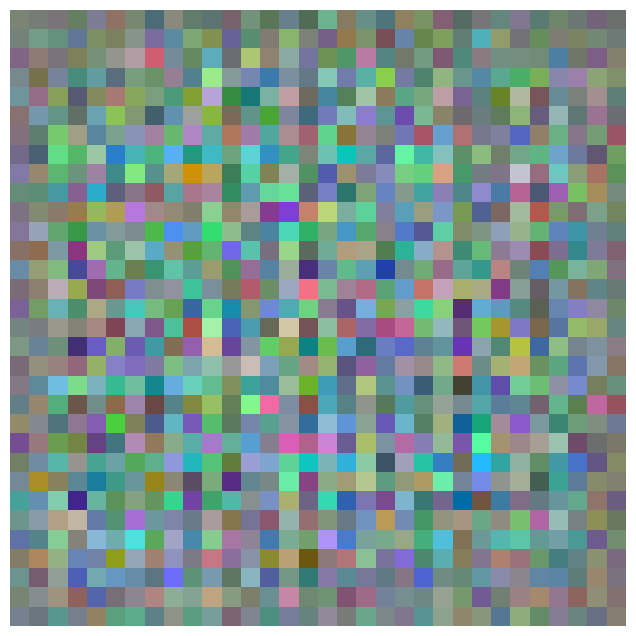

In [254]:
scale_and_display(forwarded_random_image, True)

In [255]:
# Let's ensure that the Discriminator doesn't throw any obvious errors
discriminator = Discriminator().to(device)
discriminator.forward(forwarded_random_image)

tensor([[0.4986]], device='cuda:0', grad_fn=<SigmoidBackward0>)

## Loading the data

In [256]:
def lambda_scaling(tensor):
    return tensor * 2 - 1

In [257]:
data_dir = dset.ImageFolder(
    root="./imgs",
    transform=transforms.Compose(
        [
            transforms.Resize(32),
            transforms.CenterCrop(32),
            transforms.ToTensor(),
            transforms.Lambda(lambda_scaling),
        ]
    ),
)

In [258]:
data = torch.stack([element[0] for element in data_dir]).to(device)
data.shape

torch.Size([975, 3, 32, 32])

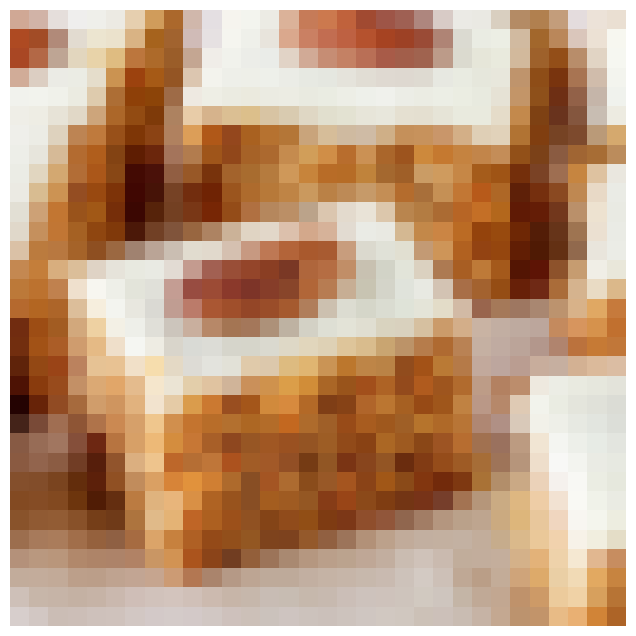

In [259]:
scale_and_display(torch.clone(data[2]).cpu())

In [260]:
data[0].shape

torch.Size([3, 32, 32])

## Example of training a non-standard model in a loop

In [261]:
class NonstandardModel(nn.Module):
    def __init__(self):
        super(NonstandardModel, self).__init__()
        self.network = nn.Sequential(
            nn.Linear(10, 128),
            nn.Dropout(0.25),
            nn.ReLU(True),
            nn.Linear(128, 128),
            nn.Dropout(0.25),
            nn.ReLU(True),
            nn.Linear(128, 1),
            nn.Sigmoid(),
        )

    def forward(self, img):
        return self.network(img)

In [262]:
my_model = NonstandardModel().to(device)
for i, param in enumerate(my_model.parameters()):
    if not i in {0, 3}:  # 0 and 3 correspond to the first 2 fully connected layers
        param.requires_grad = False

In [263]:
# copy model parameters to compare them at the end
reference_list = []
for p in my_model.parameters():
    reference_list.append(torch.clone(p))

In [264]:
batch = torch.stack([get_normal(10) for _ in range(10)])
optimizer = torch.optim.SGD(
    my_model.parameters(), lr=0.001, momentum=0.9, nesterov=True
)
for epoch in range(1000):
    y_pred = my_model(batch)
    loss = 42 - 42 * y_pred.mean()
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    if epoch % 100 == 0:
        print(loss)

tensor(20.4816, device='cuda:0', grad_fn=<RsubBackward1>)
tensor(8.6812, device='cuda:0', grad_fn=<RsubBackward1>)
tensor(4.1614, device='cuda:0', grad_fn=<RsubBackward1>)
tensor(2.4639, device='cuda:0', grad_fn=<RsubBackward1>)
tensor(2.1389, device='cuda:0', grad_fn=<RsubBackward1>)
tensor(1.4089, device='cuda:0', grad_fn=<RsubBackward1>)
tensor(0.8961, device='cuda:0', grad_fn=<RsubBackward1>)
tensor(1.1976, device='cuda:0', grad_fn=<RsubBackward1>)
tensor(0.7887, device='cuda:0', grad_fn=<RsubBackward1>)
tensor(0.7603, device='cuda:0', grad_fn=<RsubBackward1>)


In [265]:
result_list = []
for p in my_model.parameters():
    result_list.append(p)

for ref, res in zip(reference_list, result_list):
    print((ref - res).sum())

tensor(-1.0596, device='cuda:0', grad_fn=<SumBackward0>)
tensor(0., device='cuda:0')
tensor(0., device='cuda:0')
tensor(-44.6974, device='cuda:0', grad_fn=<SumBackward0>)
tensor(0., device='cuda:0')
tensor(0., device='cuda:0')


## The basic idea of discriminator training

In [266]:
BATCH_SIZE = 16

In [267]:
real_batch = data[:BATCH_SIZE]
real_labels = torch.ones(BATCH_SIZE) + torch.rand(BATCH_SIZE) * 0.05

generated_batch = generator.forward(
    torch.stack([get_normal(64) for _ in range(BATCH_SIZE)])
)
generated_labels = torch.zeros(BATCH_SIZE) - torch.rand(BATCH_SIZE) * 0.05

batch = torch.concat([real_batch, generated_batch])
labels = torch.concat([real_labels, generated_labels])
labels = labels.clip(min=0, max=1).reshape((-1, 1)).to(device)

In [268]:
discriminator_opt = torch.optim.Adam(discriminator.parameters(), lr=0.00001)
loss_function = nn.BCELoss()

In [269]:
y_pred = discriminator(batch)
loss = loss_function(y_pred, labels)

discriminator_opt.zero_grad()
loss.backward()
discriminator_opt.step()

loss

tensor(0.6274, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)

## The basic idea of generator training

In [270]:
batch = torch.stack([get_normal(64) for _ in range(BATCH_SIZE)])
labels = torch.ones(BATCH_SIZE)
labels = labels.clip(max=1).reshape((-1, 1)).to(device)

generator_opt = torch.optim.Adam(generator.parameters(), lr=0.00001)

In [271]:
images = generator(batch)
y_pred = discriminator(images)
loss = loss_function(y_pred, labels)
generator_opt.zero_grad()
loss.backward()
generator_opt.step()

loss

tensor(0.8306, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)

## Training the model

In [272]:
n_full_batches = data.shape[0] // BATCH_SIZE
n_ending_elems = data.shape[0] % BATCH_SIZE
batches = [
    data[i * BATCH_SIZE : (i + 1) * BATCH_SIZE] for i in range(n_full_batches)
] + [data[-n_ending_elems:]]

In [273]:
def save_state(dis, gen, dis_opt, gen_opt, path, epoch):
    torch.save(dis, path + "/discriminator" + str(epoch))
    torch.save(gen, path + "/generator" + str(epoch))
    torch.save(dis_opt, path + "/discriminator_optimizer" + str(epoch))
    torch.save(gen_opt, path + "/generator_optimizer" + str(epoch))


def load_state(path, epoch):
    dis = torch.load(path + "/discriminator" + str(epoch))
    gen = torch.load(path + "/generator" + str(epoch))
    dis_opt = torch.load(path + "/discriminator_optimizer" + str(epoch))
    gen_opt = torch.load(path + "/generator_optimizer" + str(epoch))
    return dis, gen, dis_opt, gen_opt

In [274]:
constant_for_comparison = torch.stack([get_normal(64) for _ in range(16)])

In [277]:
discriminator = Discriminator().to(device)
generator = Generator().to(device)
discriminator_opt = torch.optim.Adam(
    discriminator.parameters(), lr=0.00001, weight_decay=0.01
)
generator_opt = torch.optim.Adam(generator.parameters(), lr=0.005, weight_decay=0.01)
loss_function = nn.BCELoss()

epoch:  10
d loss:  tensor(0.1471, device='cuda:0', grad_fn=<DivBackward0>)
g loss:  tensor(0.7185, device='cuda:0', grad_fn=<DivBackward0>)


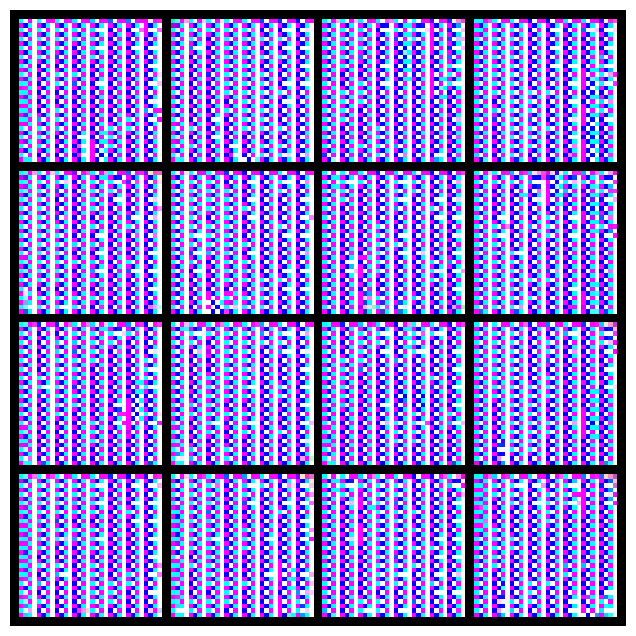

epoch:  20
d loss:  tensor(1.0977, device='cuda:0', grad_fn=<DivBackward0>)
g loss:  tensor(0.9208, device='cuda:0', grad_fn=<DivBackward0>)


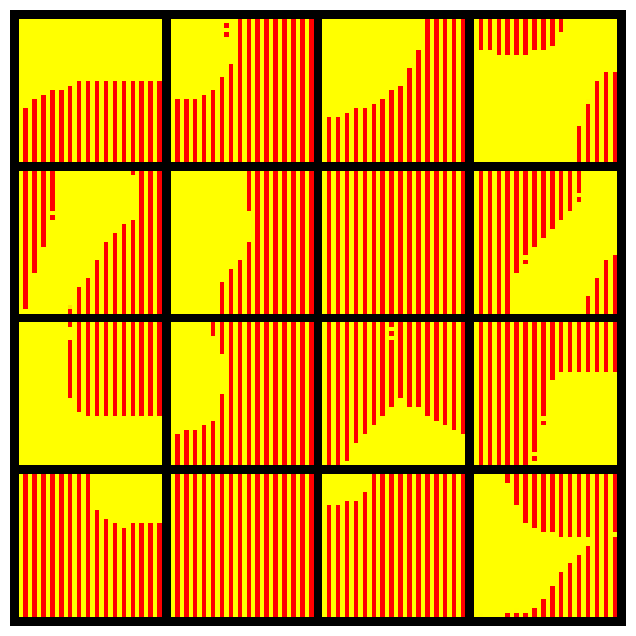

epoch:  30
d loss:  tensor(0.1302, device='cuda:0', grad_fn=<DivBackward0>)
g loss:  tensor(0.0182, device='cuda:0', grad_fn=<DivBackward0>)


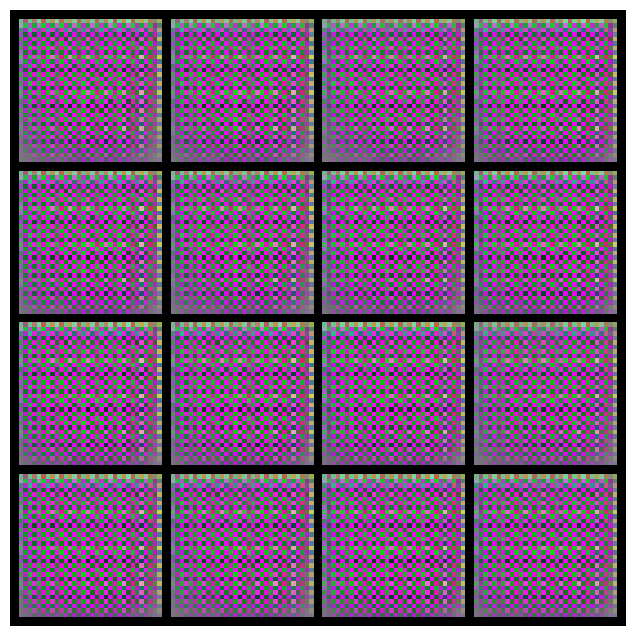

epoch:  40
d loss:  tensor(0.1595, device='cuda:0', grad_fn=<DivBackward0>)
g loss:  tensor(0.8105, device='cuda:0', grad_fn=<DivBackward0>)


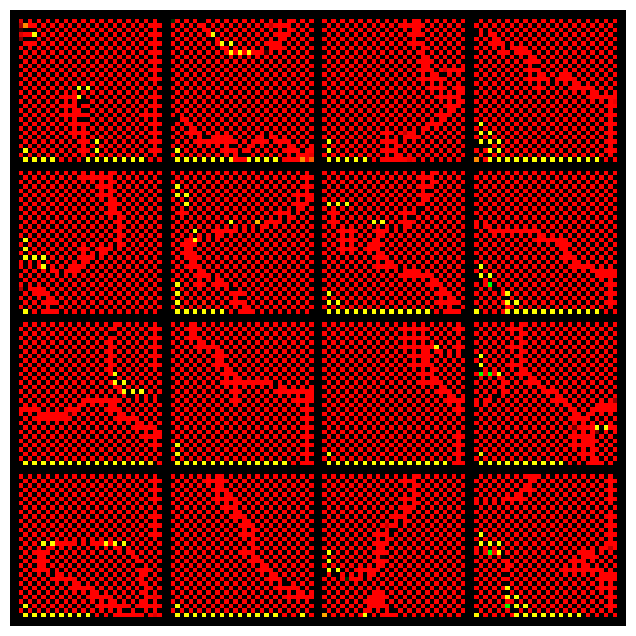

epoch:  50
d loss:  tensor(0.2674, device='cuda:0', grad_fn=<DivBackward0>)
g loss:  tensor(0.0375, device='cuda:0', grad_fn=<DivBackward0>)


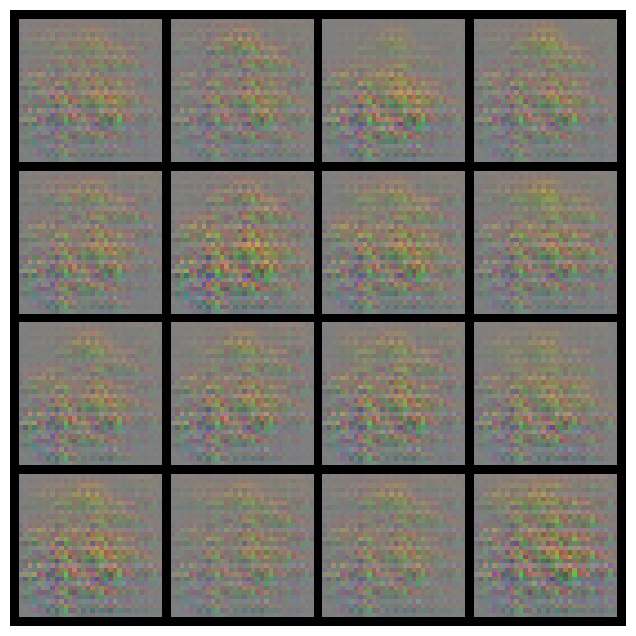

epoch:  60
d loss:  tensor(0.1191, device='cuda:0', grad_fn=<DivBackward0>)
g loss:  tensor(0.0373, device='cuda:0', grad_fn=<DivBackward0>)


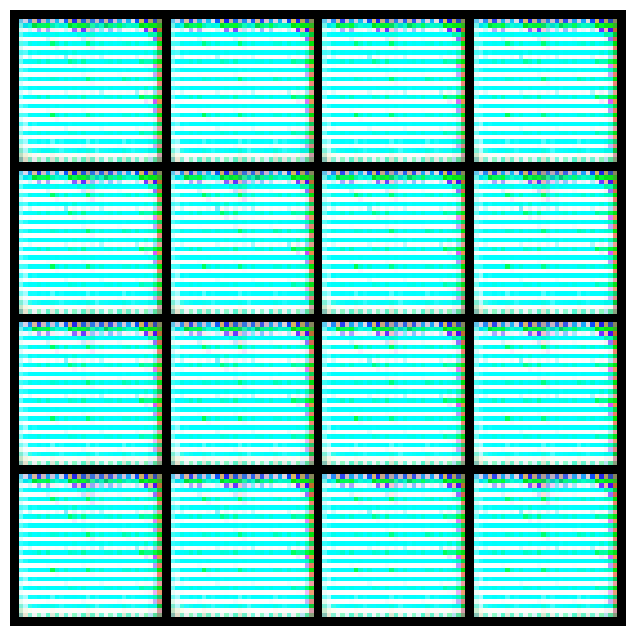

epoch:  70
d loss:  tensor(0.1206, device='cuda:0', grad_fn=<DivBackward0>)
g loss:  tensor(0.0201, device='cuda:0', grad_fn=<DivBackward0>)


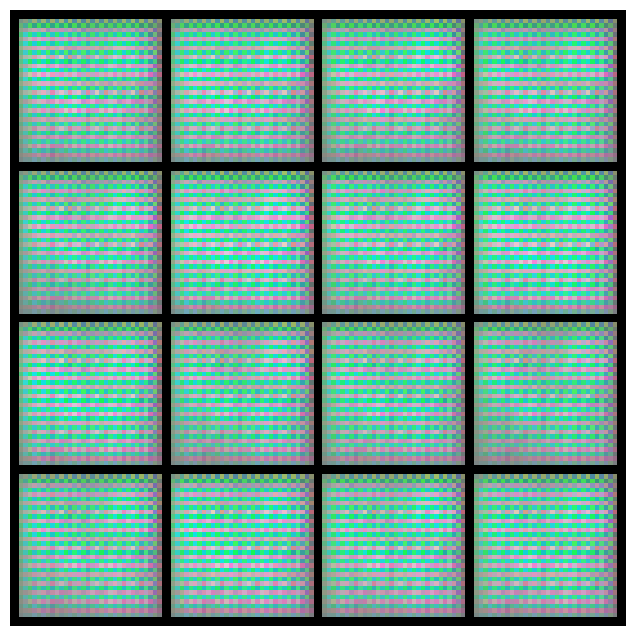

epoch:  80
d loss:  tensor(0.1975, device='cuda:0', grad_fn=<DivBackward0>)
g loss:  tensor(0.3056, device='cuda:0', grad_fn=<DivBackward0>)


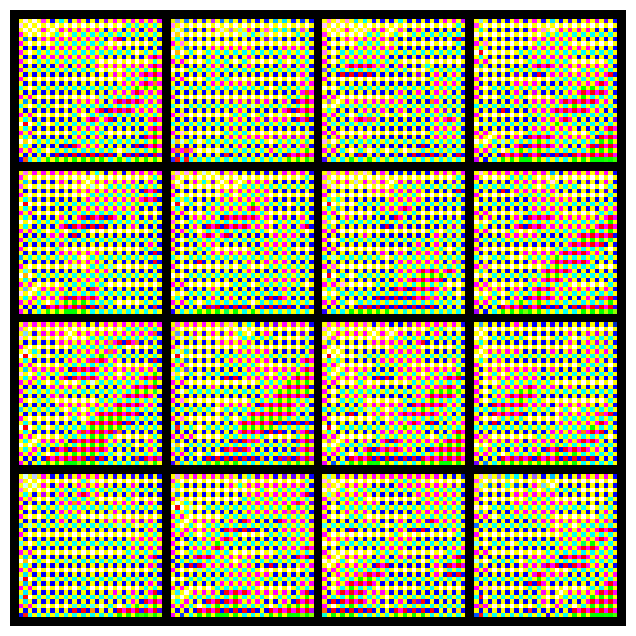

epoch:  90
d loss:  tensor(0.1205, device='cuda:0', grad_fn=<DivBackward0>)
g loss:  tensor(0.0140, device='cuda:0', grad_fn=<DivBackward0>)


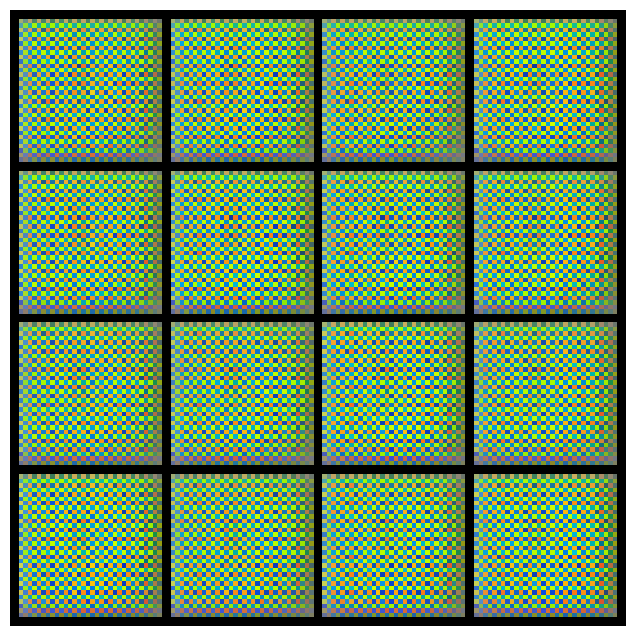

KeyboardInterrupt: 

In [278]:
epoch_loss = []
for epoch in range(3000):
    dis_loss = 0
    gen_loss = 0
    for batch in batches:
        batch_size = batch.shape[0]

        # Training discriminator
        discriminator_opt.zero_grad()
        real_labels = torch.ones(batch_size) - torch.rand(batch_size) * 0.05
        generated_batch = generator.forward(
            torch.stack(
                [torch.normal(torch.zeros(64), 1).to(device) for _ in range(batch_size)]
            )
        )
        generated_labels = torch.zeros(batch_size) + torch.rand(batch_size) * 0.05
        disc_batch = torch.concat([batch, generated_batch])
        labels = torch.concat([real_labels, generated_labels])
        labels = labels.clip(min=0, max=1).reshape((-1, 1)).to(device)
        y_pred = discriminator(disc_batch)
        loss = loss_function(y_pred, labels)
        dis_loss += loss
        loss.backward()
        discriminator_opt.step()

        # Training generator
        generator_opt.zero_grad()
        gen_batch = torch.stack([get_normal(64) for _ in range(batch_size)])
        generated_labels = torch.ones(batch_size) + torch.rand(batch_size)
        generated_labels = (
            generated_labels.clip(min=0, max=1).reshape((-1, 1)).to(device)
        )
        images = generator(gen_batch)
        y_pred = discriminator(images)
        loss = loss_function(y_pred, generated_labels)
        gen_loss += loss
        loss.backward()
        generator_opt.step()

    if epoch % 10 == 0 and epoch > 0:
        print("epoch: ", epoch)
        epoch_loss.append((dis_loss, gen_loss))
        print("d loss: ", dis_loss / len(batches))
        print("g loss: ", gen_loss / len(batches))
        save_state(
            discriminator,
            generator,
            discriminator_opt,
            generator_opt,
            "./saved_models",
            epoch,
        )
        images = generator.forward(constant_for_comparison)
        scale_and_display(images.cpu(), normalize=False)